# 1. Importing

In [64]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split

import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output
from keras import optimizers
from keras.models import load_model
from keras.callbacks import Callback

%matplotlib inline


# 2. Investigating the Data


In [65]:
features = ['MIP', 'SIP','EKIP','SKIP','MDM-SR','SDM-SR','EKDM-SR','SKDM-SR','Target'] # Abbreviating features
df =  pd.read_csv('pulsar_stars.csv',
                names=features,na_values='?',header=None, skiprows = 1)
print(df.head(6))

          MIP        SIP      EKIP      SKIP    MDM-SR     SDM-SR    EKDM-SR  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   
5   93.570312  46.698114  0.531905  0.416721  1.636288  14.545074  10.621748   

      SKDM-SR  Target  
0   74.242225       0  
1  127.393580       0  
2   63.171909       0  
3   53.593661       0  
4  252.567306       0  
5  131.394004       0  


In [66]:
# Checking information about the dtypes and non-null rows in the dataset
df.info()
print('\n Since dtypes are all floating point numbers or integers, and there are no null values in the dataset \n No need to perform cleaning')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
MIP        17898 non-null float64
SIP        17898 non-null float64
EKIP       17898 non-null float64
SKIP       17898 non-null float64
MDM-SR     17898 non-null float64
SDM-SR     17898 non-null float64
EKDM-SR    17898 non-null float64
SKDM-SR    17898 non-null float64
Target     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB

 Since dtypes are all floating point numbers or integers, and there are no null values in the dataset 
 No need to perform cleaning


In [67]:
# Getting the statistical details of the dataset
df.describe()

,MIP,SIP,EKIP,SKIP,MDM-SR,SDM-SR,EKDM-SR,SKDM-SR,Target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


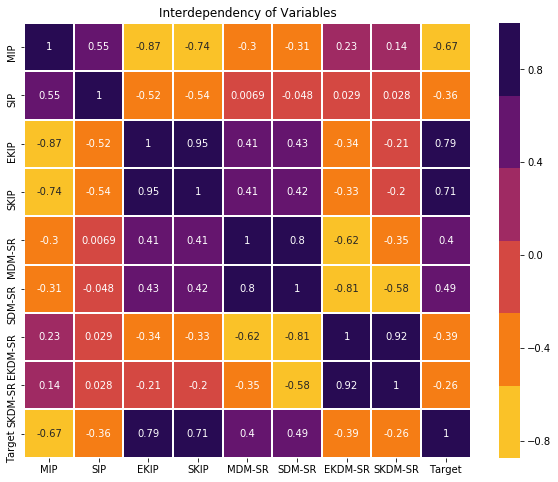

In [68]:
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("inferno_r"),
            linewidth=1,edgecolor="k")
plt.title("Interdependency of Variables")
plt.show()

# 3. Pre-Processing Data

In [69]:
# Changing dataframe to array and separating target values from feature values
pulsar_x= np.array((df.loc[:,'MIP':'SKDM-SR']))
pulsar_y= np.array((df.loc[:,'Target']))
pulsar_x=pulsar_x.reshape(pulsar_x.shape[0],8)
pulsar_y=pulsar_y.reshape(pulsar_y.shape[0],1)
print(pulsar_x.shape)
print(pulsar_y.shape)


(17898, 8)
(17898, 1)


In [70]:
# Scaling Data
x_scale = preprocessing.scale(pulsar_x)
# splitting data into a 75:25 train test split
x_train, x_test, y_train, y_test = train_test_split(x_scale, pulsar_y, test_size = .25)
y_train = y_train.reshape((y_train.shape[0]), 1)
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)

(13423, 1)
(13423, 8)
(4475, 1)


# 4. Logistic Regression Without Feature Transformation

##  4.1 With L1 Regularization:

In [71]:
# Initializing lists for different accuracy values for train and test sets corresponding to different values of parameter C
acc_train_logreg = [] 
acc_test_logreg = []
Yhat_test_logreg = []
c_logreg = []
prec_test_logreg = []
fscore_test_logreg =[]

In [72]:
def logreg_model_L1(c , X_train, Y_train, X_test, Y_test):
    # Create an object of logistic regression model using linear_model.
    
  
    logreg = linear_model.LogisticRegression(C=c,penalty='l1', warm_start=True, solver='saga', max_iter = 5000)
    
    logreg.fit(X_train, Y_train)
    
    Yhat_train = logreg.predict(X_train)
    
  
    # Adding training accuracy to acc_train_logreg
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg.append(acc_train)
    
    # Printing values of C and no. of iterations
    print("For C = %f" % c)
    print("Accuracy on training data = %f" % acc_train)
#     prec_train , recal_train , fscore_train,_ = precision_recall_fscore_support(Y_train, Yhat_train, average = 'weighted')
#     print("Precision on train data = %f" % prec)
#     print("Recal on train data = %f" % recal)
#     print("fscore on train data = %f" % fscore)
  # Find the prediction on test sets
    Yhat_test = logreg.predict(X_test)
    # Adding testing accuracy to acc_test_logreg
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_test, average = 'weighted')
    prec_test_logreg.append(prec)
    fscore_test_logreg.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
   # Find precision, recall, and fscore 
    
    # Appending value of c for graphing purposes
    c_logreg.append(c)
    Yhat_test_logreg.append(Yhat_test)

In [73]:
# Call the above function i.e. logreg_model with different values of parameter 'c'.
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]

for c in c_values:
    logreg_model_L1(c, x_train, y_train, x_test, y_test)    
    

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.907845
Accuracy on test data = 0.910168
Precision on test data = 0.828405
Recal on test data = 0.910168
fscore on test data = 0.867364


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.873328
Accuracy on test data = 0.875338
Precision on test data = 0.953599
Recal on test data = 0.951732
fscore on test data = 0.943701


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.847745
Accuracy on test data = 0.849857
Precision on test data = 0.973630
Recal on test data = 0.974302
fscore on test data = 0.973133


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.843734
Accuracy on test data = 0.845641
Precision on test data = 0.978491
Recal on test data = 0.978994
fscore on test data = 0.978362


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.842276
Accuracy on test data = 0.843441
Precision on test data = 0.979882
Recal on test data = 0.980335
fscore on test data = 0.979893


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.842154
Accuracy on test data = 0.843258
Precision on test data = 0.980117
Recal on test data = 0.980559
fscore on test data = 0.980134


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.842154
Accuracy on test data = 0.843258
Precision on test data = 0.980117
Recal on test data = 0.980559
fscore on test data = 0.980134


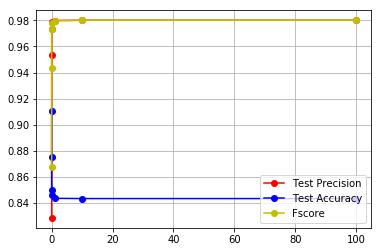

In [74]:
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='lower right')

## 4.2 With L2 Regularization

In [75]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
prec_test_logreg.clear()
fscore_test_logreg.clear()
print(prec_test_logreg)


[]


In [76]:
def logreg_model_L2(c , X_train, Y_train, X_test, Y_test):
    # Create an object of logistic regression model using linear_model.
    
  
    logreg = linear_model.LogisticRegression(C=c, warm_start=True, solver='saga', max_iter = 5000)
    
    logreg.fit(X_train, Y_train)
    
    Yhat_train = logreg.predict(X_train)
    
  
    # Adding training accuracy to acc_train_logreg
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg_L2.append(acc_train)
    
    # Printing values of C and no. of iterations
    print("For C = %f" % c)
    print("Accuracy on training data = %f" % acc_train)
#     prec_train , recal_train , fscore_train,_ = precision_recall_fscore_support(Y_train, Yhat_train, average = 'weighted')
#     print("Precision on train data = %f" % prec)
#     print("Recal on train data = %f" % recal)
#     print("fscore on train data = %f" % fscore)
  # Find the prediction on test sets
    Yhat_test = logreg.predict(X_test)
    # Adding testing accuracy to acc_test_logreg
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg_L2.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_test, average = 'weighted')
    prec_test_logreg.append(prec)
    fscore_test_logreg.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
   # Find precision, recall, and fscore 
    
    # Appending value of c for graphing purposes
    c_logreg_L2.append(c)
    Yhat_test_logreg_L2.append(Yhat_test)

In [77]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]

for c in c_values:
    logreg_model_L2(c, x_train, y_train, x_test, y_test)  

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.890647
Accuracy on test data = 0.892936
Precision on test data = 0.936012
Recal on test data = 0.931173
fscore on test data = 0.911057


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.860506
Accuracy on test data = 0.864522
Precision on test data = 0.962439
Recal on test data = 0.962235
fscore on test data = 0.958145


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.848353
Accuracy on test data = 0.850590
Precision on test data = 0.972207
Recal on test data = 0.972961
fscore on test data = 0.971656


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.844524
Accuracy on test data = 0.846557
Precision on test data = 0.977327
Recal on test data = 0.977877
fscore on test data = 0.977139


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.842762
Accuracy on test data = 0.843808
Precision on test data = 0.979412
Recal on test data = 0.979888
fscore on test data = 0.979411


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.842154
Accuracy on test data = 0.843258
Precision on test data = 0.980117
Recal on test data = 0.980559
fscore on test data = 0.980134


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.842154
Accuracy on test data = 0.843258
Precision on test data = 0.980117
Recal on test data = 0.980559
fscore on test data = 0.980134


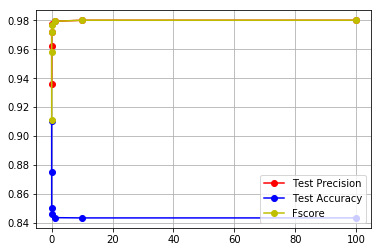

In [78]:
plt.plot(c_logreg_L2, prec_test_logreg, 'ro-') 
plt.plot(c_logreg_L2, acc_test_logreg,'bo-') 
plt.plot(c_logreg_L2, fscore_test_logreg,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='lower right')

# 4.3 Logistic Regression using Polynomial Feature Transformation
## 4.3.1 Using L1 Regularization without PCA

In [79]:
from sklearn.preprocessing import PolynomialFeatures

In [80]:
ply = PolynomialFeatures(degree = 2)

In [81]:
X_transformed_train = ply.fit_transform(x_train)
X_transformed_test = ply.fit_transform(x_test)
print(X_transformed_train.shape)
print(X_transformed_test.shape)

(13423, 45)
(4475, 45)


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.907784
Accuracy on test data = 0.910168
Precision on test data = 0.828405
Recal on test data = 0.910168
fscore on test data = 0.867364


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.870837
Accuracy on test data = 0.873138
Precision on test data = 0.956084
Recal on test data = 0.954413
fscore on test data = 0.947412


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.847745
Accuracy on test data = 0.850407
Precision on test data = 0.973924
Recal on test data = 0.974525
fscore on test data = 0.973313


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.842154
Accuracy on test data = 0.843258
Precision on test data = 0.981052
Recal on test data = 0.981453
fscore on test data = 0.981047


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.841304
Accuracy on test data = 0.841974
Precision on test data = 0.981299
Recal on test data = 0.981676
fscore on test data = 0.981354


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.841365
Accuracy on test data = 0.841608
Precision on test data = 0.981770
Recal on test data = 0.982123
fscore on test data = 0.981831


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.841365
Accuracy on test data = 0.841608
Precision on test data = 0.981770
Recal on test data = 0.982123
fscore on test data = 0.981831


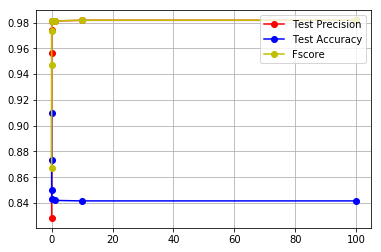

In [82]:
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
fscore_test_logreg.clear()
prec_test_logreg.clear()


# Call the function logreg_model.
for c in c_values:
    logreg_model_L1(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-')
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='upper right')
    


## 4.3.2 Using L1 Regularization with PCA


In [83]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_x_transformed_train = pca.fit_transform(X_transformed_train)
pca_x_transformed_test = pca.transform(X_transformed_test)
pca.n_components_

7

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.907845
Accuracy on test data = 0.910168
Precision on test data = 0.828405
Recal on test data = 0.910168
fscore on test data = 0.867364


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.870837
Accuracy on test data = 0.873138
Precision on test data = 0.956084
Recal on test data = 0.954413
fscore on test data = 0.947412


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.847745
Accuracy on test data = 0.850407
Precision on test data = 0.973924
Recal on test data = 0.974525
fscore on test data = 0.973313


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.842154
Accuracy on test data = 0.843258
Precision on test data = 0.981052
Recal on test data = 0.981453
fscore on test data = 0.981047


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.841304
Accuracy on test data = 0.841974
Precision on test data = 0.981299
Recal on test data = 0.981676
fscore on test data = 0.981354


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.841365
Accuracy on test data = 0.841608
Precision on test data = 0.981770
Recal on test data = 0.982123
fscore on test data = 0.981831


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.841365
Accuracy on test data = 0.841608
Precision on test data = 0.981770
Recal on test data = 0.982123
fscore on test data = 0.981831


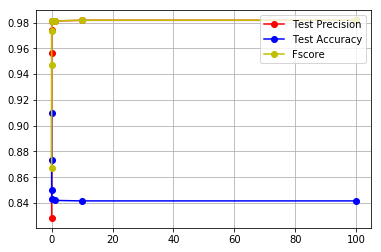

In [84]:
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
fscore_test_logreg.clear()
prec_test_logreg.clear()

# Call the function logreg_model.
for c in c_values:
    logreg_model_L1(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-')
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')
    

## 4.3.3 Using L2 Regularization without PCA

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.866097
Accuracy on test data = 0.868738
Precision on test data = 0.958629
Recal on test data = 0.957989
fscore on test data = 0.952546


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.853032
Accuracy on test data = 0.856456
Precision on test data = 0.968938
Recal on test data = 0.969385
fscore on test data = 0.967187


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.847137
Accuracy on test data = 0.848757
Precision on test data = 0.975510
Recal on test data = 0.976089
fscore on test data = 0.975100


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.842884
Accuracy on test data = 0.843991
Precision on test data = 0.980588
Recal on test data = 0.981006
fscore on test data = 0.980543


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.841851
Accuracy on test data = 0.842708
Precision on test data = 0.981288
Recal on test data = 0.981676
fscore on test data = 0.981310


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.841486
Accuracy on test data = 0.842158
Precision on test data = 0.981063
Recal on test data = 0.981453
fscore on test data = 0.981116


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.841486
Accuracy on test data = 0.842158
Precision on test data = 0.981063
Recal on test data = 0.981453
fscore on test data = 0.981116


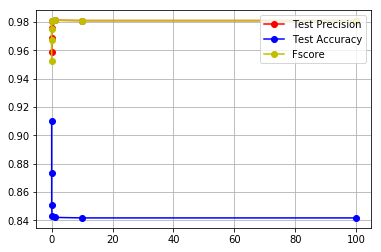

In [85]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
fscore_test_logreg.clear()
prec_test_logreg.clear()
# Call the function logreg_model.
for c in c_values:
    logreg_model_L2(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')
    


## 4.3.4 Using L2 regularization with PCA

In [86]:
pca = PCA(.95)
pca_x_transformed_train = pca.fit_transform(X_transformed_train)
pca_x_transformed_test = pca.transform(X_transformed_test)
pca.n_components_

7

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.866097
Accuracy on test data = 0.868738
Precision on test data = 0.958629
Recal on test data = 0.957989
fscore on test data = 0.952546


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.853032
Accuracy on test data = 0.856456
Precision on test data = 0.968938
Recal on test data = 0.969385
fscore on test data = 0.967187


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.847137
Accuracy on test data = 0.848757
Precision on test data = 0.975510
Recal on test data = 0.976089
fscore on test data = 0.975100


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.842884
Accuracy on test data = 0.843991
Precision on test data = 0.980588
Recal on test data = 0.981006
fscore on test data = 0.980543


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.841851
Accuracy on test data = 0.842708
Precision on test data = 0.981288
Recal on test data = 0.981676
fscore on test data = 0.981310


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.841486
Accuracy on test data = 0.842158
Precision on test data = 0.981063
Recal on test data = 0.981453
fscore on test data = 0.981116


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.841486
Accuracy on test data = 0.842158
Precision on test data = 0.981063
Recal on test data = 0.981453
fscore on test data = 0.981116


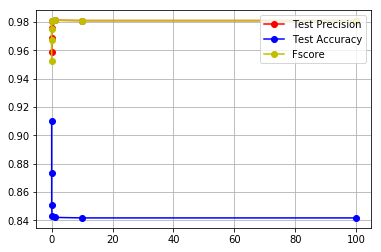

In [87]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
fscore_test_logreg.clear()
prec_test_logreg.clear()
# Call the function logreg_model.
for c in c_values:
    logreg_model_L2(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')

# 5. Support Vector Machine (SVM)

## 5.1 Using Linear Kernel

In [88]:
acc_train_svm_linear = []
acc_test_svm_linear = []
c_svm_linear = []
prec_test_svm_linear = []
fscore_test_svm_linear = []

In [89]:
from sklearn import svm

# Complete the function below:
# In this function and next 2 functions, we are not passing the data matrices as parameters 
# because we can use global variables inside the functions.
def svm_linear(c, X_train, Y_train, X_test, Y_test):
    # TODO - Create an object of svm.SVC(probability = False, kernel = 'linear', C = c) - 5 points
    svc_linear = svm.SVC(probability = False, kernel = 'linear', C = c)
    
    # TODO - Fit the classifier on the training set - 5 points
    svc_linear.fit(X_train, Y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    Yhat_svc_linear_train = svc_linear.predict(X_train)
    acc_train = np.mean(Yhat_svc_linear_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_linear.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    Yhat_svc_linear_test = svc_linear.predict(X_test)
    acc_test = np.mean(Yhat_svc_linear_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_linear.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_linear_test, average = 'weighted')
    prec_test_svm_linear.append(prec)
    fscore_test_svm_linear.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    
    # Appending value of c for graphing purposes
    c_svm_linear.append(c)
    

In [90]:
print(c_values)
for c in c_values:
    svm_linear(c,x_train,y_train, x_test, y_test)


[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.869925
Test Accuracy = 0.872221
Precision on test data = 0.955827
Recal on test data = 0.954637
fscore on test data = 0.947905


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.853579
Test Accuracy = 0.856823
Precision on test data = 0.970591
Recal on test data = 0.970726
fscore on test data = 0.968579


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.847684
Test Accuracy = 0.848940
Precision on test data = 0.975768
Recal on test data = 0.976313
fscore on test data = 0.975317


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.843734
Test Accuracy = 0.845091
Precision on test data = 0.980138
Recal on test data = 0.980559
fscore on test data = 0.980011


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.842884
Test Accuracy = 0.843624
Precision on test data = 0.980585
Recal on test data = 0.981006
fscore on test data = 0.980567


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.842701
Test Accuracy = 0.843074
Precision on test data = 0.980819
Recal on test data = 0.981229
fscore on test data = 0.980830


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.842641
Test Accuracy = 0.843074
Precision on test data = 0.980819
Recal on test data = 0.981229
fscore on test data = 0.980830


[0.8722213663743329, 0.8568228956649293, 0.8489403451827346, 0.8450907275053837, 0.8436242064854406, 0.8430742611029618, 0.8430742611029618]


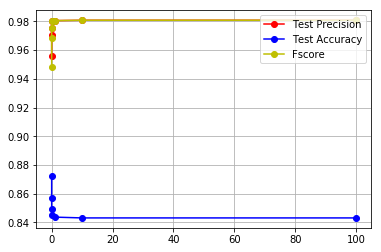

In [91]:
print(acc_test_svm_linear)
# Plot training accuracy(Y-axis) v/s 'c' on X - Axis.
# Plot test accuracy(Y-Axis) v/s 'c' on X - Axis.

plt.plot(c_svm_linear, prec_test_svm_linear, 'ro-') 
plt.plot(c_svm_linear, acc_test_svm_linear,'bo-') 
plt.plot(c_svm_linear, fscore_test_svm_linear,'yo-') 
plt.grid()

# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='upper right')

## 5.2 Using Radial Basis Function (RBF) Kernel

In [92]:
acc_train_svm_rbf = []
acc_test_svm_rbf = []
c_svm_rbf = []
prec_test_svm_rbf = []
fscore_test_svm_rbf = []

In [93]:
from sklearn import svm

# Complete the function below:
# In this function and next 2 functions, we are not passing the data matrices as parameters 
# because we can use global variables inside the functions.
def svm_rbf(c,X_train,Y_train, X_test, Y_test):
    # TODO - Create an object of svm.SVC(probability = False, kernel = 'rbf', C = c) - 5 points
    svc_rbf = svm.SVC(probability = False, kernel = 'rbf', C = c)
    
    # TODO - Fit the classifier on the trai  ning set - 5 points
    svc_rbf.fit(X_train, Y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    Yhat_svc_rbf_train = svc_rbf.predict(X_train)
    acc_train = np.mean(Yhat_svc_rbf_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_rbf.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    Yhat_svc_rbf_test = svc_rbf.predict(X_test)
    acc_test = np.mean(Yhat_svc_rbf_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_rbf.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_rbf_test, average = 'weighted')
    prec_test_svm_rbf.append(prec)
    fscore_test_svm_rbf.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    # Appending value of c for graphing purposes
    c_svm_rbf.append(c)
    

In [94]:
for c in c_values:
    svm_rbf(c,x_train,y_train, x_test, y_test)

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.907845
Test Accuracy = 0.910168
Precision on test data = 0.828405
Recal on test data = 0.910168
fscore on test data = 0.867364


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.907845
Test Accuracy = 0.910168
Precision on test data = 0.828405
Recal on test data = 0.910168
fscore on test data = 0.867364


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.854430
Test Accuracy = 0.855723
Precision on test data = 0.971403
Recal on test data = 0.971620
fscore on test data = 0.969669


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.845861
Test Accuracy = 0.847657
Precision on test data = 0.978832
Recal on test data = 0.979218
fscore on test data = 0.978442


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.842276
Test Accuracy = 0.843074
Precision on test data = 0.979418
Recal on test data = 0.979888
fscore on test data = 0.979461


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.841790
Test Accuracy = 0.842891
Precision on test data = 0.980587
Recal on test data = 0.981006
fscore on test data = 0.980614


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.840878
Test Accuracy = 0.841974
Precision on test data = 0.980836
Recal on test data = 0.981229
fscore on test data = 0.980900


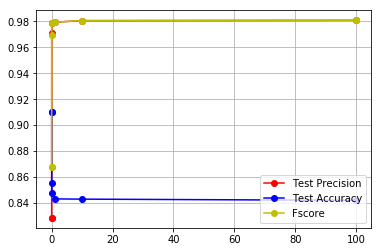

In [95]:
plt.plot(c_svm_rbf, prec_test_svm_rbf, 'ro-') 
plt.plot(c_svm_rbf, acc_test_svm_rbf,'bo-') 
plt.plot(c_svm_rbf, fscore_test_svm_rbf,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='lower right')

## 5.3 Using Polynomial Kernel

In [96]:
acc_train_svm_poly = []
acc_test_svm_poly = []
c_svm_poly = []
prec_test_svm_poly = []
fscore_test_svm_poly = []

In [97]:
def svm_polynomial(c,X_train,Y_train, X_test, Y_test):
    # TODO - Create an object of svm.SVC(probability = False, kernel = 'poly', C = c) - 5 points
    svc_polynomial = svm.SVC(probability = False, kernel = 'poly', C = c)

    
    # TODO - Fit the classifier on the training set - 5 points
    # Use A and B to train and C and D to test.
    svc_polynomial.fit(X_train, Y_train)
    # TODO - Find the prediction and accuracy on the training set - 5 points
    Yhat_svc_polynomial_train = svc_polynomial.predict(X_test)
    acc_train = np.mean(Yhat_svc_polynomial_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_poly.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    # TODO - Find the prediction and accuracy on the test set - 5 points
    Yhat_svc_polynomial_test = svc_polynomial.predict(X_test)
    acc_test = np.mean(Yhat_svc_polynomial_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_poly.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_polynomial_test, average = 'weighted')
    prec_test_svm_poly.append(prec)
    fscore_test_svm_poly.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    # Appending value of c for graphing purposes
    c_svm_poly.append(c)

In [98]:
for c in c_values:
    svm_polynomial(c,x_train,y_train, x_test, y_test)

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.872483
Test Accuracy = 0.874604
Precision on test data = 0.952400
Recal on test data = 0.951285
fscore on test data = 0.943391


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.862822
Test Accuracy = 0.864889
Precision on test data = 0.961422
Recal on test data = 0.961341
fscore on test data = 0.957085


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.853708
Test Accuracy = 0.855723
Precision on test data = 0.970362
Recal on test data = 0.970726
fscore on test data = 0.968714


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.848787
Test Accuracy = 0.850773
Precision on test data = 0.972967
Recal on test data = 0.973631
fscore on test data = 0.972340


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.845141
Test Accuracy = 0.847107
Precision on test data = 0.977110
Recal on test data = 0.977654
fscore on test data = 0.976864


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.842772
Test Accuracy = 0.844724
Precision on test data = 0.979183
Recal on test data = 0.979665
fscore on test data = 0.979118


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.841860
Test Accuracy = 0.843808
Precision on test data = 0.978943
Recal on test data = 0.979441
fscore on test data = 0.978953


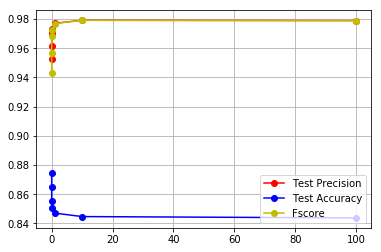

In [99]:
plt.plot(c_svm_poly,prec_test_svm_poly, 'ro-') 
plt.plot(c_svm_poly,acc_test_svm_poly,'bo-')
plt.plot(c_svm_poly,fscore_test_svm_poly,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='lower right')


# 6. Neural Networks
In the following section, we will run our data set through various neural networks with different hyper parameters. We will vary the activation function (tanh, reLU, sigmoid), the number of inputs in the hidden layer (10, 100, 200), and the number of hidden layers (1, 2, 5, with 100 nodes in each hidden layer). Weights and biases will be initialized randomly.  

In [100]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
     self.val_f1s = []
     self.val_recalls = []
     self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
     val_predict = (np.asarray(self.model.predict(self.validation_data[0])).round())
     val_targ = self.validation_data[1]
     _val_f1 = f1_score(val_targ, val_predict)
     _val_recall = recall_score(val_targ, val_predict)
     _val_precision = precision_score(val_targ, val_predict)
    
     self.val_f1s.append(_val_f1)
     self.val_recalls.append(_val_recall)
     self.val_precisions.append(_val_precision)
        
     print (" — val_f1: %f — val_precision: %f — val_recall %f" % 
            (_val_f1, _val_precision, _val_recall))
     return

metrics = Metrics()


# Build and compile our network with user given parameters
def neural_network(nin, nh, nout, nhl, act):
    model = Sequential();
    for x in range(0,nhl):
        model.add(Dense(nh, input_shape=(nin,), activation=act, name="hidden"+str(x)))
    model.add(Dense(nout, activation="sigmoid", name="output"))  
    # Compile model
    opt = optimizers.Adam(lr=0.001) 
    model.compile(optimizer=opt, 
             loss="binary_crossentropy",
             metrics=["accuracy"])  
    return model

# Train and validate our network on training and test data
def train_network(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, epochs=10, batch_size=100, 
                validation_data=(x_test, y_test), callbacks=[metrics], verbose=1)
    return history

# Plot network accuracy
def plot_acc(history, title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

# Plot network loss
def plot_loss(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='upper right')
    plt.show()
    


# 6.1 Network 8-100-1, Sigmoid

Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 56us/step - loss: 0.1806 - acc: 0.9392 - val_loss: 0.1194 - val_acc: 0.9622
 — val_f1: 0.742770 — val_precision: 0.956863 — val_recall 0.606965
Epoch 2/10
13423/13423 [==============================] - 0s 18us/step - loss: 0.1073 - acc: 0.9680 - val_loss: 0.0981 - val_acc: 0.9707
 — val_f1: 0.814710 — val_precision: 0.944262 — val_recall 0.716418
Epoch 3/10
13423/13423 [==============================] - 0s 16us/step - loss: 0.0949 - acc: 0.9724 - val_loss: 0.0900 - val_acc: 0.9727
 — val_f1: 0.831492 — val_precision: 0.934783 — val_recall 0.748756
Epoch 4/10
13423/13423 [==============================] - 0s 18us/step - loss: 0.0892 - acc: 0.9730 - val_loss: 0.0860 - val_acc: 0.9743
 — val_f1: 0.846051 — val_precision: 0.915942 — val_recall 0.786070
Epoch 5/10
13423/13423 [==============================] - 0s 18us/step - loss: 0.0859 - acc: 0.9748 - val_loss: 0.0829 - val_acc: 0

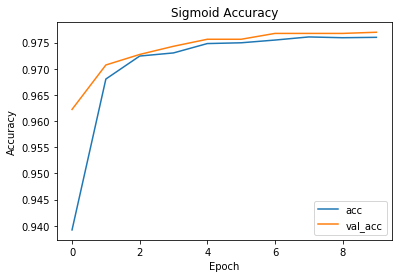

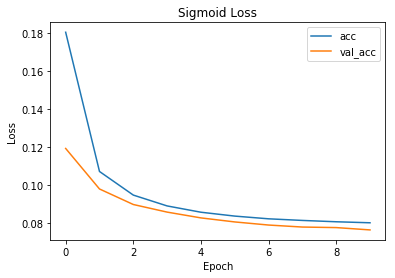

Validation Accuracy = 0.976983


In [101]:
K.clear_session()

modelArr = []
historyArr = []
modelNameArr = []
# Number of nodes in input layer = number of features = 8
nin = x_train.shape[1];
# Number of hidden layer nodes
nh = 100;
# Number of output nodes
nout = 1;


model_sig = neural_network(nin, nh, nout, 1, "sigmoid")
sig_history = train_network(model_sig, x_train, y_train, x_test, y_test);
model_sig.summary()
plot_acc(sig_history, "Sigmoid Accuracy")
plot_loss(sig_history, "Sigmoid Loss")

modelArr.append(model_sig)
historyArr.append(sig_history)
modelNameArr.append("model_sig")

score, acc = model_sig.evaluate(x_test, y_test, verbose = 0)
print("Validation Accuracy = %f" % acc)


## 6.2 Network 8-100-1, ReLU

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 63us/step - loss: 0.3147 - acc: 0.9177 - val_loss: 0.1194 - val_acc: 0.9770
 — val_f1: 0.860999 — val_precision: 0.941003 — val_recall 0.793532
Epoch 2/10
13423/13423 [==============================] - 0s 16us/step - loss: 0.0949 - acc: 0.9756 - val_loss: 0.0822 - val_acc: 0.9770
 — val_f1: 0.862850 — val_precision: 0.928367 — val_recall 0.805970
Epoch 3/10
13423/13423 [==============================] - 0s 16us/step - loss

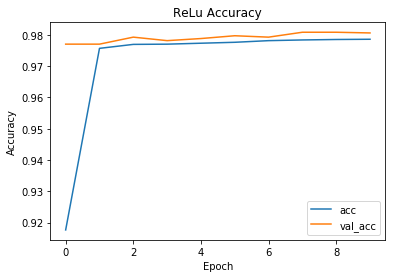

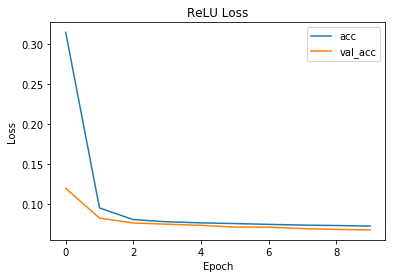

Accuracy = 0.980559


In [102]:
nh = 100;
    
model_relu = neural_network(nin, nh, nout, 1, "relu")
model_relu.summary()
relu_history = train_network(model_relu, x_train, y_train, x_test, y_test);
plot_acc(relu_history, "ReLu Accuracy")
plot_loss(relu_history, "ReLU Loss")

modelArr.append(model_relu)
historyArr.append(relu_history)
modelNameArr.append("model_relu")

score, acc = model_relu.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.3 Network 8-100-1, tanh

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 60us/step - loss: 0.3004 - acc: 0.9350 - val_loss: 0.1132 - val_acc: 0.9761
 — val_f1: 0.853625 — val_precision: 0.948328 — val_recall 0.776119
Epoch 2/10
13423/13423 [==============================] - 0s 18us/step - loss: 0.0927 - acc: 0.9753 - val_loss: 0.0803 - val_acc: 0.9783
 — val_f1: 0.869799 — val_precision: 0.944606 — val_recall 0.805970
Epoch 3/10
13423/13423 [==============================] - 0s 19us/step - loss

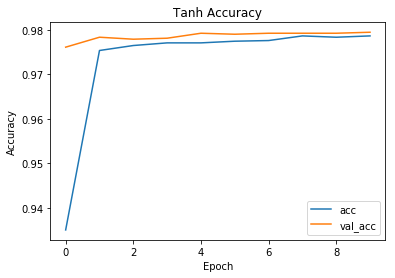

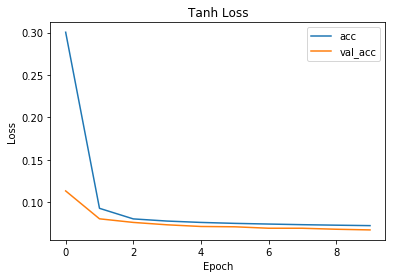

Accuracy = 0.979441


In [103]:
nh = 100;
    
model_tanh = neural_network(nin, nh, nout, 1, "relu")
model_tanh.summary()
tanh_history = train_network(model_tanh, x_train, y_train, x_test, y_test);
plot_acc(tanh_history, "Tanh Accuracy")
plot_loss(tanh_history, "Tanh Loss")

modelArr.append(model_tanh)
historyArr.append(tanh_history)
modelNameArr.append("model_tanh")

score, acc = model_tanh.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.4 Network 8-10-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 10)                90        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 50us/step - loss: 0.4587 - acc: 0.9039 - val_loss: 0.3280 - val_acc: 0.9484
 — val_f1: 0.670471 — val_precision: 0.785953 — val_recall 0.584577
Epoch 2/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.2627 - acc: 0.9583 - val_loss: 0.2149 - val_acc: 0.9613
 — val_f1: 0.745214 — val_precision: 0.913357 — val_recall 0.629353
Epoch 3/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.

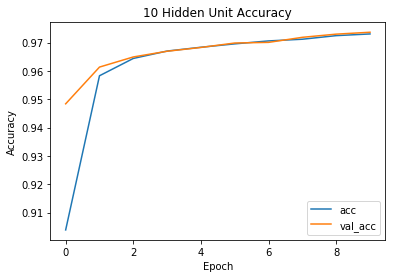

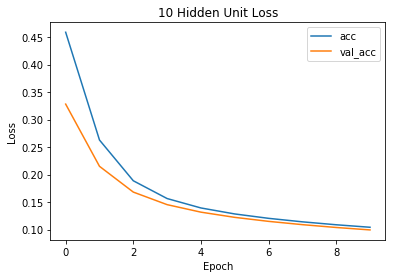

Accuracy = 0.973631


In [104]:
# We are changing the number of hidden units here
nh = 10;
    
model_ten = neural_network(nin, nh, nout, 1, "sigmoid")
model_ten.summary()
ten_history = train_network(model_ten, x_train, y_train, x_test, y_test);
plot_acc(ten_history, "10 Hidden Unit Accuracy")
plot_loss(ten_history, "10 Hidden Unit Loss")

modelArr.append(model_ten)
historyArr.append(ten_history)
modelNameArr.append("model_ten")

score, acc = model_ten.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.5 Network 8-200-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 200)               1800      
_________________________________________________________________
output (Dense)               (None, 1)                 201       
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 77us/step - loss: 0.1775 - acc: 0.9425 - val_loss: 0.1127 - val_acc: 0.9649
 — val_f1: 0.766716 — val_precision: 0.952030 — val_recall 0.641791
Epoch 2/10
13423/13423 [==============================] - 0s 23us/step - loss: 0.1028 - acc: 0.9689 - val_loss: 0.0962 - val_acc: 0.9716
 — val_f1: 0.825309 — val_precision: 0.923077 — val_recall 0.746269
Epoch 3/10
13423/13423 [==============================] - 0s 23us/step - loss

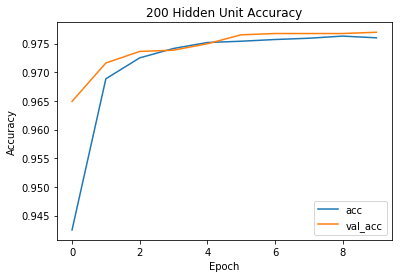

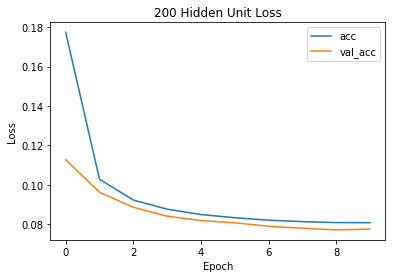

Accuracy = 0.976983


In [105]:
nh = 200;
    
model_twohund = neural_network(nin, nh, nout, 1, "sigmoid")
model_twohund.summary()
twohund_history = train_network(model_twohund, x_train, y_train, x_test, y_test);
plot_acc(twohund_history, "200 Hidden Unit Accuracy")
plot_loss(twohund_history, "200 Hidden Unit Loss")

modelArr.append(model_twohund)
historyArr.append(twohund_history)
modelNameArr.append("model_twohund")

score, acc = model_twohund.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.6 Network 8-100-100-1 sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 86us/step - loss: 0.2479 - acc: 0.8979 - val_loss: 0.1436 - val_acc: 0.9560
 — val_f1: 0.680713 — val_precision: 0.976744 — val_recall 0.522388
Epoch 2/10
13423/13423 [==============================] - 0s 23us/step - loss: 0.1140 - acc: 0.9662 - val_loss: 0.0958 - val_acc: 0.9709
 — val_f1: 

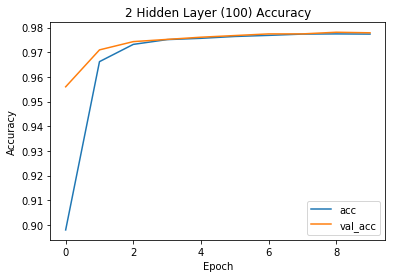

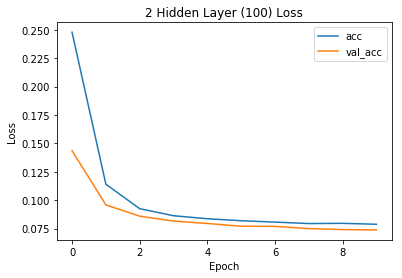

Accuracy = 0.977877


In [106]:
nh = 100;
num_layers = 2;
    
model_twolayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_twolayer.summary()
twolayer_history = train_network(model_twolayer, x_train, y_train, x_test, y_test);
plot_acc(twolayer_history, "2 Hidden Layer (100) Accuracy")
plot_loss(twolayer_history, "2 Hidden Layer (100) Loss")

modelArr.append(model_twolayer)
historyArr.append(twolayer_history)
modelNameArr.append("model_twolayer")

score, acc = model_twolayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.7 Network 8-100-100-100-100-100-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden4 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
_________________________________________________________________
Train 

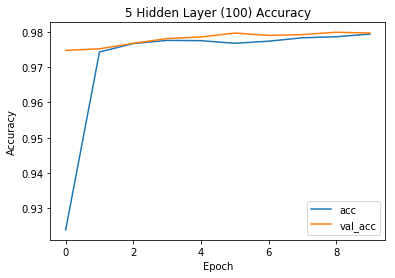

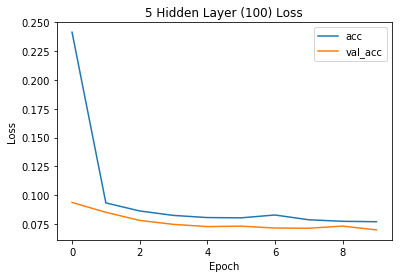

Accuracy = 0.979665


In [107]:
nh = 100;
num_layers = 5;
    
model_fivelayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_fivelayer.summary()
fivelayer_history = train_network(model_fivelayer, x_train, y_train, x_test, y_test);
plot_acc(fivelayer_history, "5 Hidden Layer (100) Accuracy")
plot_loss(fivelayer_history, "5 Hidden Layer (100) Loss")

modelArr.append(model_fivelayer)
historyArr.append(fivelayer_history)
modelNameArr.append("model_fivelayer")

score, acc = model_fivelayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Accuracy Graphs of All Models

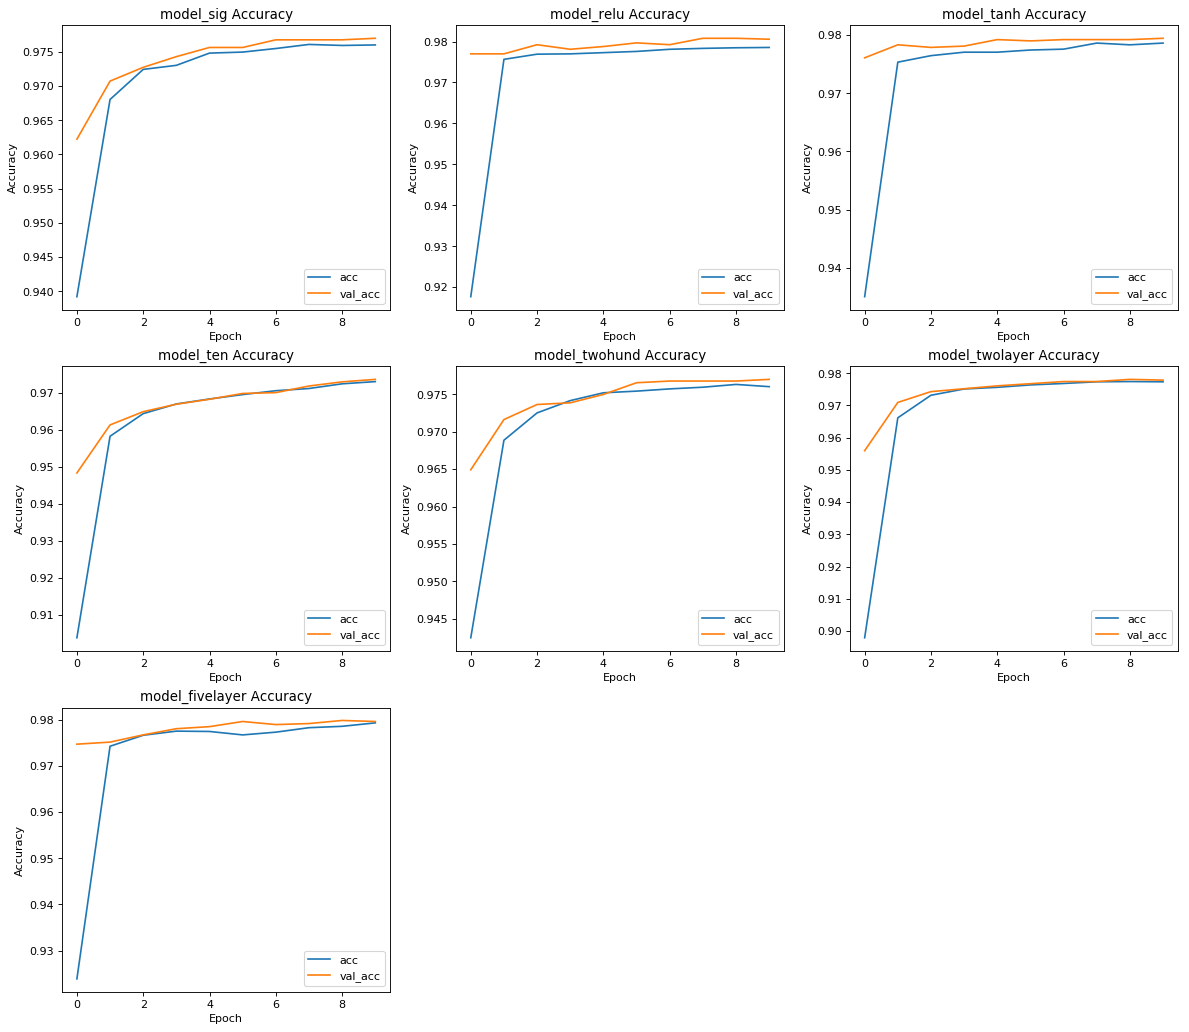

In [108]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(modelNameArr[index] + " Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')

plt.show()

## Loss Graphs of All Models

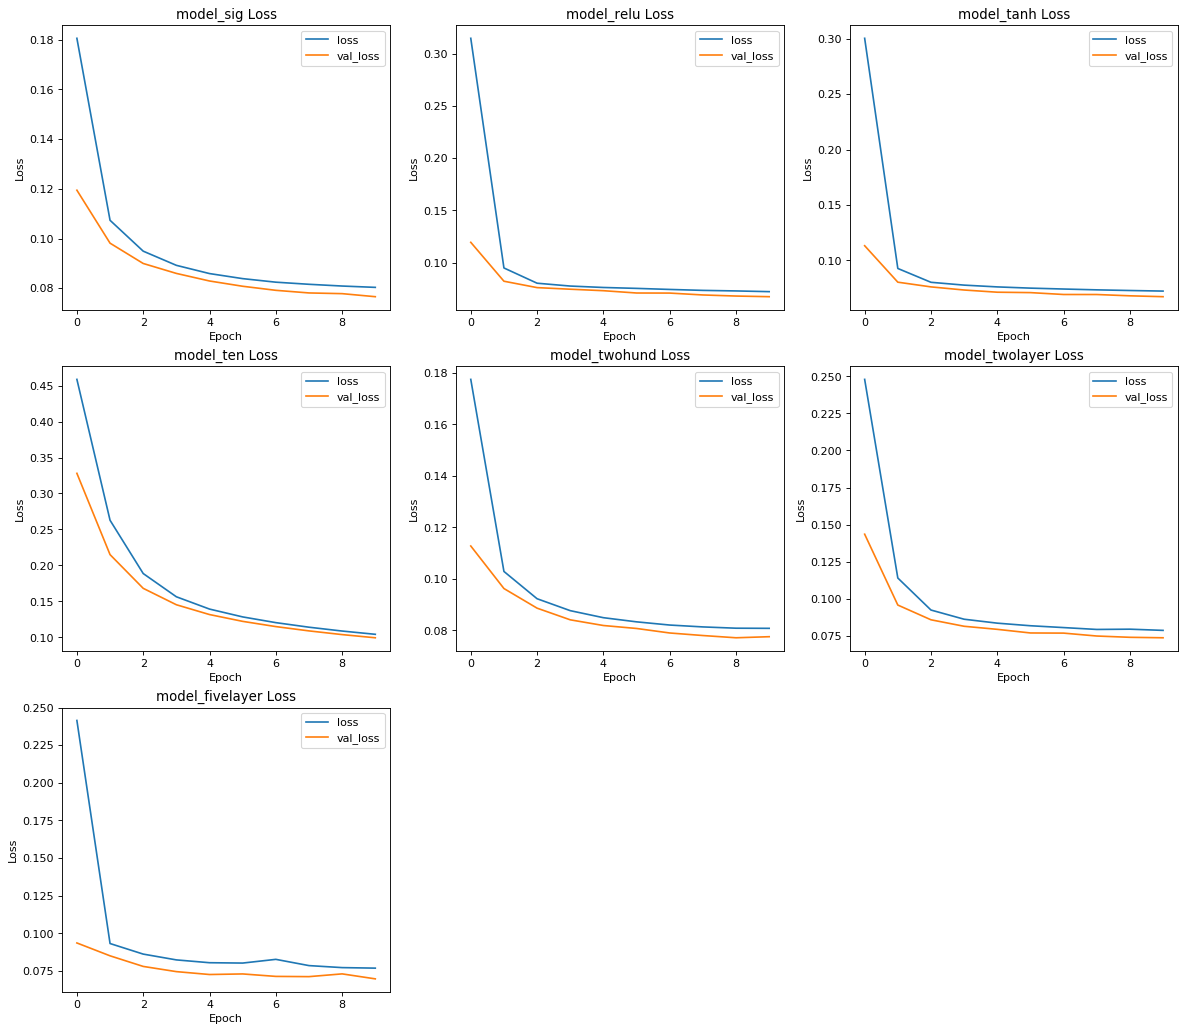

In [109]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelNameArr[index] + " Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

## Final Accuracies of all models after 10 Epochs

In [110]:
for index, model in enumerate(modelArr):
    score, acc = model.evaluate(x_test, y_test, verbose = 0)
    print(modelNameArr[index] + " Validation Accuracy = " + "{:.3%}".format(acc))

print('\n')

for index, history in enumerate(historyArr):
    
    print(modelNameArr[index] + " Train Accuracy = " + 
          "{:.3%}".format(history.history["acc"][9]))

model_sig Validation Accuracy = 97.698%
model_relu Validation Accuracy = 98.056%
model_tanh Validation Accuracy = 97.944%
model_ten Validation Accuracy = 97.363%
model_twohund Validation Accuracy = 97.698%
model_twolayer Validation Accuracy = 97.788%
model_fivelayer Validation Accuracy = 97.966%


model_sig Train Accuracy = 97.601%
model_relu Train Accuracy = 97.854%
model_tanh Train Accuracy = 97.862%
model_ten Train Accuracy = 97.303%
model_twohund Train Accuracy = 97.601%
model_twolayer Train Accuracy = 97.735%
model_fivelayer Train Accuracy = 97.936%
